# PartC_PCA y Kmeans

## Celda 1 – Cargar embeddings y elegir modelo


In [48]:
import json
import pandas as pd
import numpy as np
from pathlib import Path

# Cargamos el archivo que generaste en la Parte B
emb_path = Path("../data/embeddings/embeddings_all.json")
with open(emb_path, "r", encoding="utf-8") as f:
    emb_data = json.load(f)

df_emb = pd.DataFrame(emb_data)
print("Filas totales en embeddings_all.json:", len(df_emb))
df_emb.head()


Filas totales en embeddings_all.json: 216


,sign,date,interpreter,model,embedding_vector
0,Escorpio,2025-10-31,lecturas,gpt-4o,"[-0.04393622651696205, -0.05103103443980217, -..."
1,Leo,2025-10-30,lecturas,gpt-4o,"[-0.02682875283062458, -0.01003431249409914, -..."
2,Cancer,2025-10-31,hola,gpt-4o,"[-0.007350745610892773, 0.0041490341536700726,..."
3,Escorpio,2025-10-29,hola,gpt-4o,"[-0.009680372662842274, -0.024309322237968445,..."
4,Tauro,2025-10-31,20minutos,gpt-4o,"[-0.020668312907218933, -0.009459679014980793,..."


## Celda 2 – Elegir modelo del cual tomaremos embeddings y aplicar PCA

In [49]:
from sklearn.decomposition import PCA


MODEL_TO_USE = "gpt-4o"

df_model = df_emb[df_emb["model"] == MODEL_TO_USE].copy()
print("Usando modelo:", MODEL_TO_USE, "| filas:", len(df_model))

# Convertimos a matriz de features
X = np.array(df_model["embedding_vector"].tolist())

# PCA a 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df_model["pca1"] = X_pca[:, 0]
df_model["pca2"] = X_pca[:, 1]

print("Varianza explicada (2D):", pca.explained_variance_ratio_.sum())
df_model.head()

Usando modelo: gpt-4o | filas: 108
Varianza explicada (2D): 0.3336209222935009


,sign,date,interpreter,model,embedding_vector,pca1,pca2
0,Escorpio,2025-10-31,lecturas,gpt-4o,"[-0.04393622651696205, -0.05103103443980217, -...",0.481478,0.340561
1,Leo,2025-10-30,lecturas,gpt-4o,"[-0.02682875283062458, -0.01003431249409914, -...",-0.143938,0.267417
2,Cancer,2025-10-31,hola,gpt-4o,"[-0.007350745610892773, 0.0041490341536700726,...",-0.253310,0.008117
3,Escorpio,2025-10-29,hola,gpt-4o,"[-0.009680372662842274, -0.024309322237968445,...",-0.203550,-0.032926
4,Tauro,2025-10-31,20minutos,gpt-4o,"[-0.020668312907218933, -0.009459679014980793,...",0.520381,-0.171847


## Celda 3 – PCA a 2D

In [50]:
from sklearn.decomposition import PCA

# Convertimos la lista de floats a matriz NumPy
X = np.array(emb_model["embedding_vector"].tolist())

# Aplicamos PCA a 2 componentes
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Guardamos en el DataFrame para graficar
emb_model["pca1"] = X_pca[:, 0]
emb_model["pca2"] = X_pca[:, 1]

print("Varianza explicada por las 2 componentes:", pca.explained_variance_ratio_.sum())
emb_model[["sign", "interpreter", "date", "pca1", "pca2"]].head()


Varianza explicada por las 2 componentes: 0.3336209222935009


,sign,interpreter,date,pca1,pca2
0,Escorpio,lecturas,2025-10-31,0.481478,0.340561
1,Leo,lecturas,2025-10-30,-0.143938,0.267417
2,Cancer,hola,2025-10-31,-0.253310,0.008117
3,Escorpio,hola,2025-10-29,-0.203550,-0.032926
4,Tauro,20minutos,2025-10-31,0.520381,-0.171847


## Celda 3 — Gráfica por día

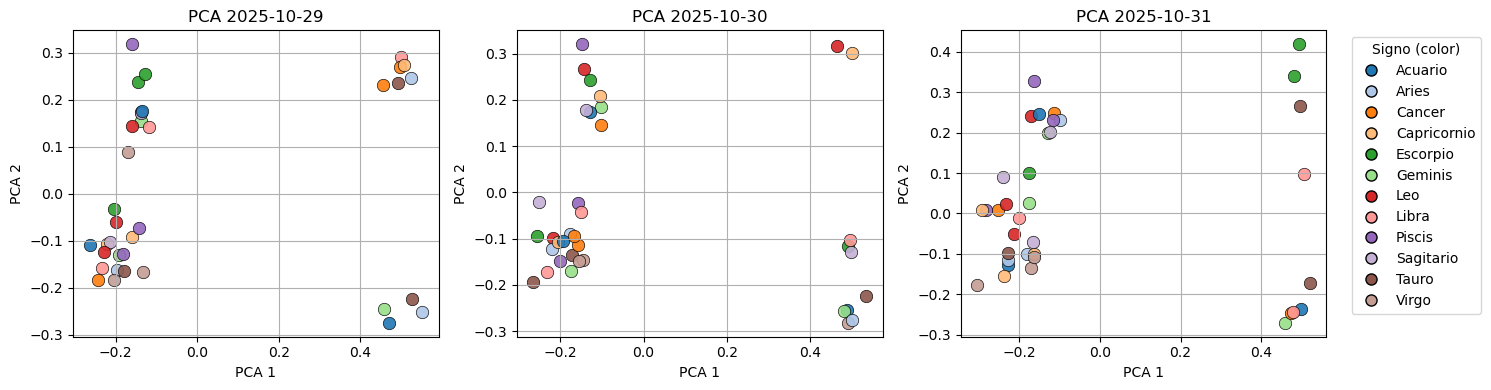

In [51]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# 1) Cargar embeddings si no existen en memoria
if "df_emb" not in globals():
    emb_path = Path("data/embeddings/embeddings_all.json")
    with open(emb_path, "r", encoding="utf-8") as f:
        emb_data = json.load(f)
    df_emb = pd.DataFrame(emb_data)

# 2) Escoger modelo
MODEL_TO_USE = "gpt-4o"
df_model = df_emb[df_emb["model"] == MODEL_TO_USE].copy()

# 3) PCA 2D
if not {"pca1", "pca2"}.issubset(df_model.columns):
    X = np.array(df_model["embedding_vector"].tolist(), dtype=float)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    df_model["pca1"] = X_pca[:, 0]
    df_model["pca2"] = X_pca[:, 1]

# 4) Graficar por día: color = signo
signs = sorted(df_model["sign"].unique())
color_map = {s: plt.cm.tab20(i) for i, s in enumerate(signs)}
days = sorted(df_model["date"].unique())

plt.figure(figsize=(15, 4))

for i, day in enumerate(days):
    sub = df_model[df_model["date"] == day]
    plt.subplot(1, 3, i + 1)
    for _, row in sub.iterrows():
        plt.scatter(
            row["pca1"],
            row["pca2"],
            c=[color_map.get(row["sign"], "gray")],
            marker="o",          # 👈 todos iguales
            s=80,
            edgecolors="k",
            linewidths=0.5,
            alpha=0.9,
        )
    plt.title(f"PCA {day}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)

# Leyenda solo de signos
sign_legend = [
    Line2D(
        [0], [0],
        marker="o",
        color="w",
        label=s,
        markerfacecolor=color_map[s],
        markersize=8,
        markeredgecolor="k"
    )
    for s in signs
]

plt.legend(
    handles=sign_legend,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Signo (color)"
)

plt.tight_layout()
plt.show()


## Celda 4 — K-Means con k = 12

In [52]:
from sklearn.cluster import KMeans

k = 12
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_model["cluster"] = kmeans.fit_predict(X)

print("Clusters asignados:", df_model["cluster"].value_counts().sort_index())


Clusters asignados: cluster
0     10
1      9
2      8
3      7
4     11
5     19
6      4
7      5
8     13
9      3
10    12
11     7
Name: count, dtype: int64


In [53]:
import pandas as pd

# df_model ya debe tener:
# - una columna "sign" (Aries, Tauro, ...)
# - una columna "cluster" (0..11) que salió de KMeans

clusters_detail = []

for c in sorted(df_model["cluster"].unique()):
    sub = df_model[df_model["cluster"] == c]

    total = len(sub)
    counts = sub["sign"].value_counts()

    # signo dominante (el que más sale en ese cluster)
    dominant_sign = counts.index[0]
    dominant_count = counts.iloc[0]
    dominant_pct = round(dominant_count / total * 100, 1)

    # por si quieres ver el segundo más común
    if len(counts) > 1:
        second_sign = counts.index[1]
        second_pct = round(counts.iloc[1] / total * 100, 1)
    else:
        second_sign = ""
        second_pct = 0.0

    clusters_detail.append({
        "cluster": c,
        "total_puntos": total,
        "signo_dominante": dominant_sign,
        "pct_dominante": dominant_pct,
        "segundo_signo": second_sign,
        "pct_segundo": second_pct,
    })

cluster_df = pd.DataFrame(clusters_detail).sort_values("cluster")
cluster_df


,cluster,total_puntos,signo_dominante,pct_dominante,segundo_signo,pct_segundo
0,0,10,Escorpio,20.0,Libra,20.0
1,1,9,Cancer,33.3,Escorpio,33.3
2,2,8,Leo,25.0,Piscis,12.5
3,3,7,Acuario,42.9,Escorpio,14.3
4,4,11,Virgo,36.4,Aries,18.2
5,5,19,Capricornio,15.8,Geminis,10.5
6,6,4,Escorpio,25.0,Virgo,25.0
7,7,5,Geminis,60.0,Cancer,20.0
8,8,13,Geminis,30.8,Acuario,23.1
9,9,3,Piscis,100.0,,0.0


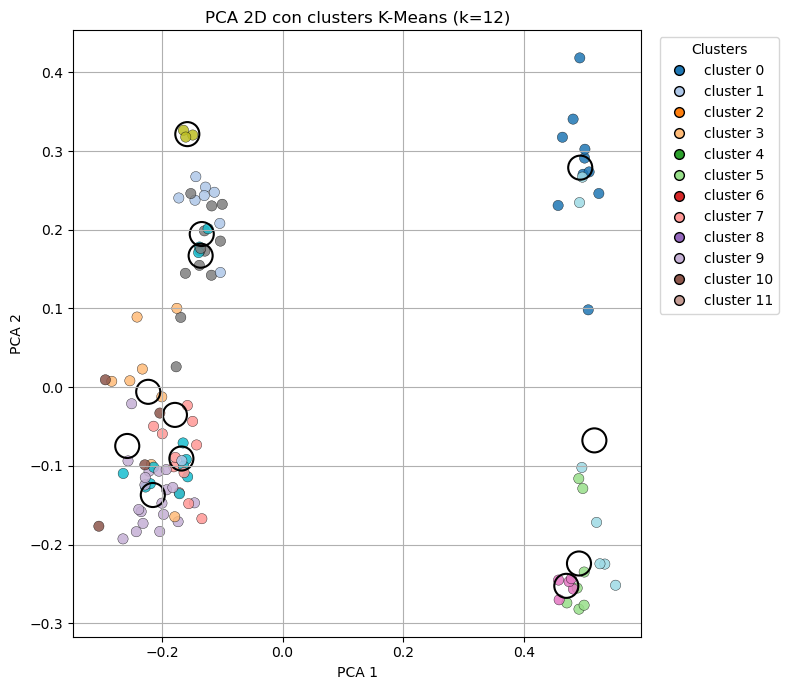

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# df_model: debe tener pca1, pca2, cluster
# cluster_df: la tabla que hicimos con cluster, signo_dominante, etc.

plt.figure(figsize=(8, 7))

# 1) puntos individuales coloreados por cluster
plt.scatter(
    df_model["pca1"],
    df_model["pca2"],
    c=df_model["cluster"],
    cmap="tab20",
    s=55,
    alpha=0.85,
    edgecolors="k",
    linewidths=0.3,
)

plt.title("PCA 2D con clusters K-Means (k=12)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

# 2) dibujar solo los centroides (sin texto)
for _, row in cluster_df.iterrows():
    c = row["cluster"]
    sub = df_model[df_model["cluster"] == c]
    center_x = sub["pca1"].mean()
    center_y = sub["pca2"].mean()

    plt.scatter(
        center_x,
        center_y,
        s=300,
        facecolors="none",
        edgecolors="black",
        linewidths=1.5
    )

# 3) leyenda de los clusters
clusters = sorted(df_model["cluster"].unique())
legend_elems = [
    Line2D(
        [0], [0],
        marker="o",
        color="w",
        label=f"cluster {c}",
        markerfacecolor=plt.cm.tab20(c),
        markersize=7,
        markeredgecolor="k",
    )
    for c in clusters
]

plt.legend(
    handles=legend_elems,
    title="Clusters",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
)

plt.tight_layout()
plt.show()


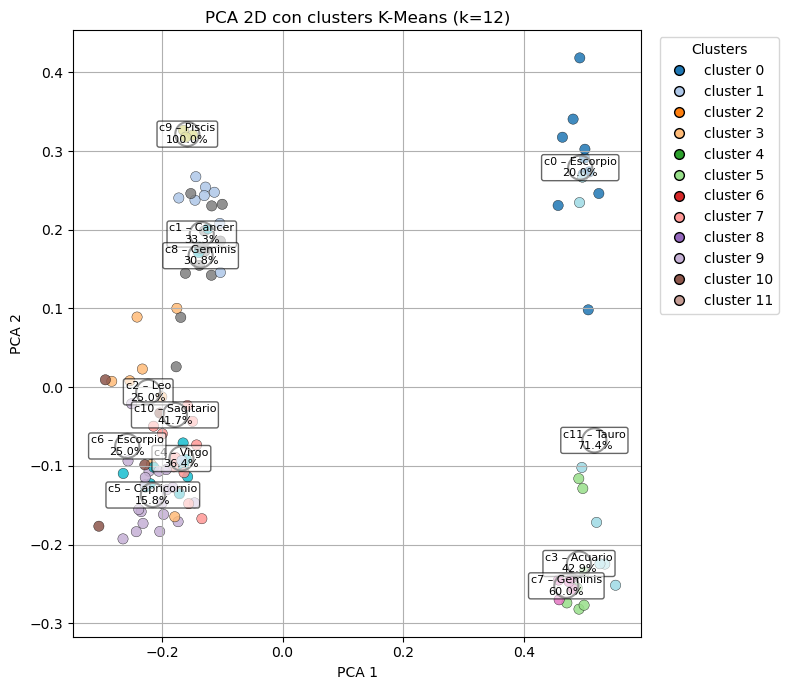

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# df_model ya debe tener: pca1, pca2, sign, cluster
# cluster_df es el que hicimos antes con signo_dominante

# 1) scatter de todos los puntos coloreados por cluster
plt.figure(figsize=(8, 7))

scatter = plt.scatter(
    df_model["pca1"],
    df_model["pca2"],
    c=df_model["cluster"],
    cmap="tab20",
    s=55,
    alpha=0.85,
    edgecolors="k",
    linewidths=0.3,
)

plt.title("PCA 2D con clusters K-Means (k=12)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

# 2) calcular centroide PCA de cada cluster para dibujarlo más grande
for _, row in cluster_df.iterrows():
    c = row["cluster"]
    dom_sign = row["signo_dominante"]
    pct = row["pct_dominante"]

    sub = df_model[df_model["cluster"] == c]
    center_x = sub["pca1"].mean()
    center_y = sub["pca2"].mean()

    # punto grande en el centro del cluster
    plt.scatter(
        center_x,
        center_y,
        s=300,
        facecolors="none",
        edgecolors="black",
        linewidths=1.5
    )

    # texto encima del centro
    plt.text(
        center_x,
        center_y,
        f"c{c} – {dom_sign}\n{pct}%",
        ha="center",
        va="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6)
    )

# 3) leyenda de clusters (opcional)
clusters = sorted(df_model["cluster"].unique())
legend_elems = [
    Line2D(
        [0], [0],
        marker="o",
        color="w",
        label=f"cluster {c}",
        markerfacecolor=plt.cm.tab20(c),
        markersize=7,
        markeredgecolor="k",
    )
    for c in clusters
]

plt.legend(
    handles=legend_elems,
    title="Clusters",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
)

plt.tight_layout()
plt.show()
